In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import time
import sys
from skimage.metrics import structural_similarity as ssim
import seaborn as sns
from sbi.inference import MNLE
from sbi.utils import MultipleIndependent
import torch
from torch.distributions import Beta, Binomial, Gamma, Uniform
from sbi.analysis import pairplot
import matplotlib.pylab as pl
import arviz as az
import time
from pybads import BADS

# sys.path.append("C:/Users/Alexandre/Documents/GitHub/")  # Alex
sys.path.append("C:/Users/agarcia/Documents/GitHub/custom_utils")  # Alex CRM
# sys.path.append("/home/garciaduran/custom_utils")  # Cluster Alex
# sys.path.append("/home/jordi/Repos/custom_utils/")  # Jordi

from utilsJ.Models.extended_ddm_v2 import trial_ev_vectorized,\
    data_augmentation, get_data_and_matrix
from utilsJ.Behavior.plotting import binned_curve
import utilsJ.Models.dirichletMultinomialEstimation as dme
from utilsJ.Models.optimization import simulation

C:\Users\agarcia\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# DATA_FOLDER = 'C:/Users/Alexandre/Desktop/CRM/Alex/paper/data/'  # Alex
# DATA_FOLDER = '/home/garciaduran/data/'  # Cluster Alex
# DATA_FOLDER = '/home/jordi/DATA/Documents/changes_of_mind/data_clean/'  # Jordi
DATA_FOLDER = 'C:/Users/agarcia/Desktop/CRM/Alex/paper/data/'  # Alex CRM

# SV_FOLDER = 'C:/Users/Alexandre/Desktop/CRM/Results_LE43/'  # Alex
# SV_FOLDER = '/home/garciaduran/opt_results/'  # Cluster Alex
# SV_FOLDER = '/home/jordi/DATA/Documents/changes_of_mind/opt_results/'  # Jordi
SV_FOLDER = 'C:/Users/agarcia/Desktop/CRM/Alex/paper/'  # Alex CRM

In [3]:
BINS = np.arange(1, 320, 20)

First, we load the data from a certain rat 

In [4]:
pright = None
num_times_tr = 1
num_trials_training = int(1e4)
index = np.arange(num_trials_training)
# load real data
subject = 'LE43'
df = get_data_and_matrix(dfpath=DATA_FOLDER + subject, return_df=True,
                         sv_folder=SV_FOLDER, after_correct=True,
                         silent=True, all_trials=True,
                         srfail=True)
mt = df.resp_len.values
choice = df.R_response.values
zt = np.nansum(df[["dW_lat", "dW_trans"]].values, axis=1)
stim = np.array([stim for stim in df.res_sound])
coh = np.array(df.coh2)
trial_index = np.array(df.origidx)
com = np.array(df.CoM_sugg)
gt = np.array(df.rewside) * 2 - 1
print('Ended loading data')


Loading data
Ended loading data


Now, we build prior distros

In [5]:
# 1. Parameters' prior distro definition
prior = MultipleIndependent([Uniform(torch.tensor([1e-1]),
                                     torch.tensor([1])),  # prior weight
                             Uniform(torch.tensor([1e-3]),
                                     torch.tensor([0.8])),  # stim weight
                             Uniform(torch.tensor([1e-2]),
                                     torch.tensor([3.])),  # evidence integrator bound
                             Uniform(torch.tensor([1e-8]),
                                     torch.tensor([1.])),  # CoM bound
                             Uniform(torch.tensor([4.]),
                                     torch.tensor([12.])),  # afferent time
                             Uniform(torch.tensor([4.]),
                                     torch.tensor([12.])),  # efferent time
                             Uniform(torch.tensor([9.]),
                                     torch.tensor([16.])),  # time offset action
                             Uniform(torch.tensor([1e-2]),
                                     torch.tensor([0.08])),  # intercept trial index for action drift
                             Uniform(torch.tensor([1e-7]),
                                     torch.tensor([5e-5])),  # slope trial index for action drift
                             Uniform(torch.tensor([0.5]),
                                     torch.tensor([4.])),  # bound for action integrator
                             Uniform(torch.tensor([10.]),
                                     torch.tensor([100.])),  # weight of evidence at first readout (for MT reduction)
                             Uniform(torch.tensor([10.]),
                                     torch.tensor([100.])),  # weight of evidence at second readout
                             Uniform(torch.tensor([0.2]),
                                     torch.tensor([0.9])),  # leak
                             Uniform(torch.tensor([1.]),
                                     torch.tensor([35.])),  # std of the MT noise
                             Uniform(torch.tensor([120.]),
                                     torch.tensor([400.])),  # MT offset
                             Uniform(torch.tensor([0.06]),
                                     torch.tensor([0.5]))],  # MT slope with trial index
                            validate_args=False)
# 2. Def. theta_o as a prior sample
theta_o = prior.sample((1,))

In [6]:
labels = ['prior weight', 'stim weight', 'EA bound', 'CoM bound', 't aff', 't eff', 'tAction', 'intercept AI', 'slope AI',
          'AI bound', 'DV weight 1st readout', 'DV weight 2nd readout', 'leak', 'MT noise std', 'MT offset', 'MT slope T.I.']
# 3. define all theta space with samples from prior
num_simulations = 250000
theta_all = prior.sample((num_simulations,))

Prior distributions plots:

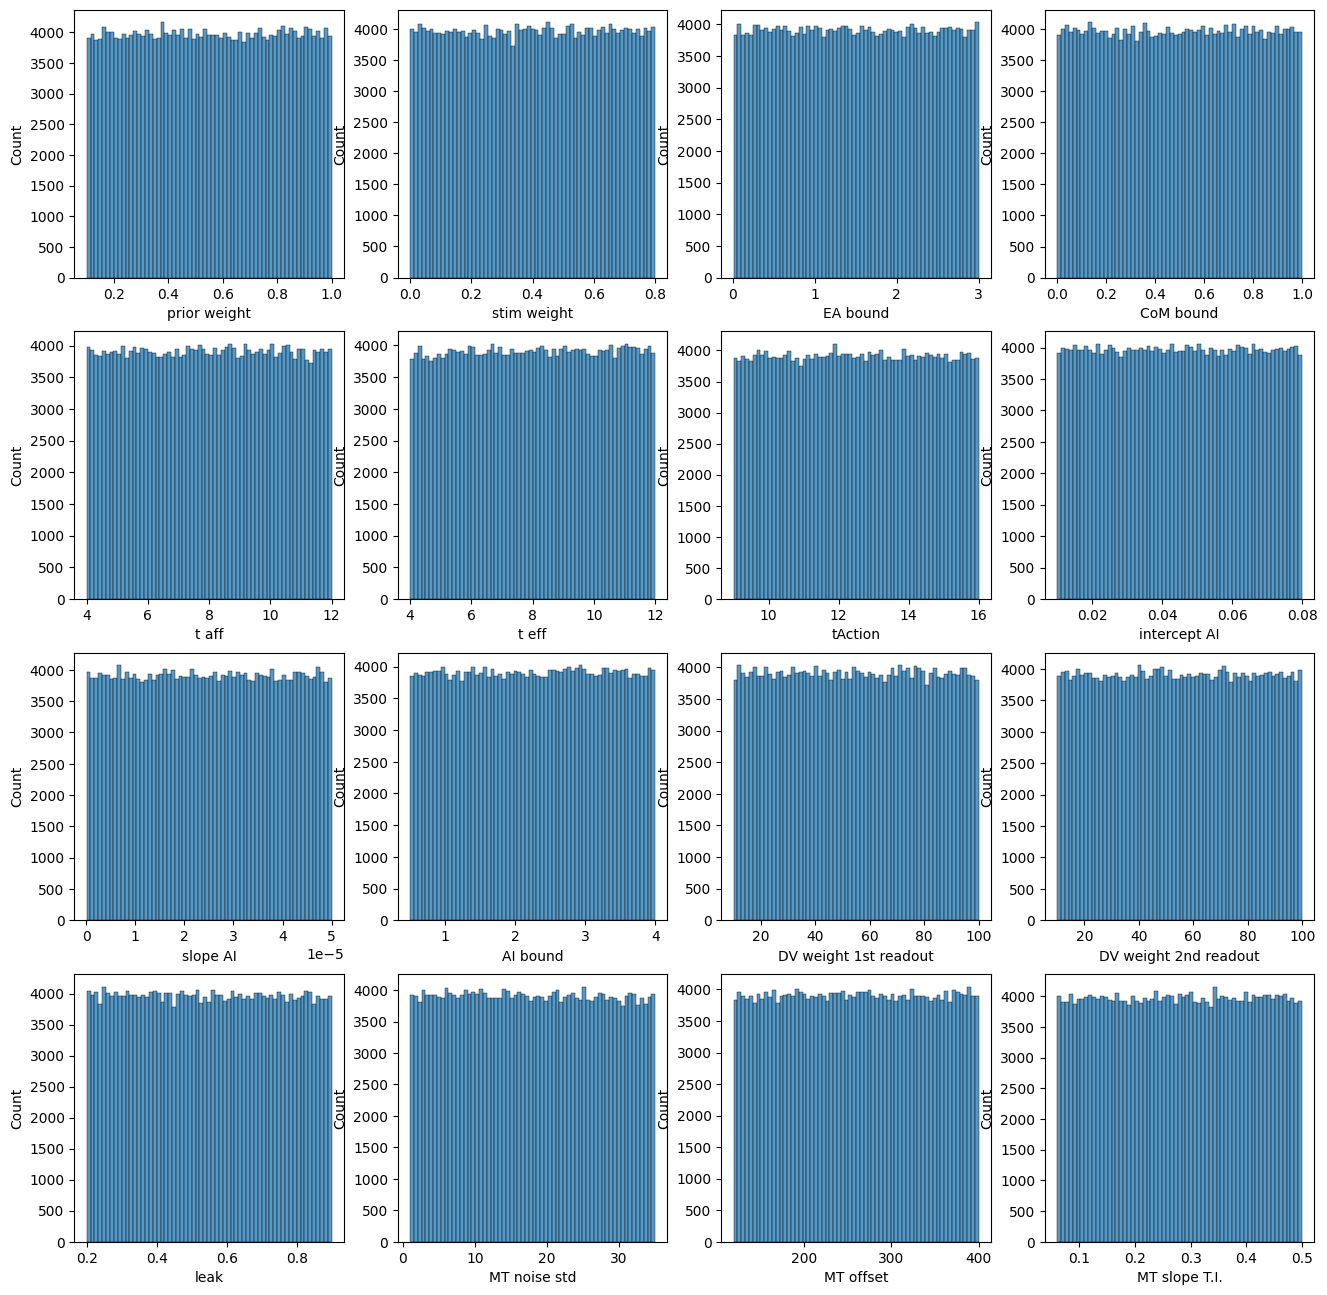

In [7]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(16,16))
ax = ax.flatten()
for iax in range(len(ax)):
    sns.histplot(theta_all[:, iax], ax=ax[iax])
    ax[iax].set_xlabel(labels[iax])
plt.show()

Now we proceed to simulate 250000 <b>different trials</b> (one for each different combination of parameters extracted from the prior distro). The function ```simulation``` simulates the model and returns a tensor with three columns: Motor Time, detected CoM & Choice.

In [8]:
# Prepare data:
coh = np.resize(coh, num_simulations)
zt = np.resize(zt, num_simulations)
trial_index = np.resize(trial_index, num_simulations)
stim = np.resize(stim, (num_simulations, 20))
gt = np.resize(gt, num_simulations)
mt = np.resize(mt, num_simulations)
choice = np.resize(choice, num_simulations)
com = np.resize(com, num_simulations)
reac_time = np.resize(df.sound_len.values, num_simulations)
choice_and_com = com + choice*2

x_o = torch.column_stack((torch.tensor(mt*1e3), torch.tensor(choice_and_com)))
# x_o = torch.column_stack((torch.tensor(mt*1e3), torch.tensor(reac_time), torch.tensor(choice)))
x_o = x_o.to(torch.float32)

In [9]:
# run simulations
x = torch.tensor(())
print('Starting simulation')
for i_t, theta in enumerate(theta_all):
    if (i_t+1) % 50000 == 0 and i_t != 0:
        print('Simulation number: ' + str(i_t+1))
    p_w_zt = float(theta[0])
    p_w_stim = float(theta[1])
    p_e_bound = float(theta[2])
    p_com_bound = float(theta[3])*p_e_bound
    p_t_aff = int(np.round(theta[4]))
    p_t_eff = int(np.round(theta[5]))
    p_t_a = int(np.round(theta[6]))
    p_w_a_intercept = float(theta[7])
    p_w_a_slope = -float(theta[8])
    p_a_bound = float(theta[9])
    p_1st_readout = float(theta[10])
    p_2nd_readout = float(theta[11])
    p_leak = float(theta[12])
    p_mt_noise = float(theta[13])
    p_mt_intercept = float(theta[14])
    p_mt_slope = float(theta[15])
    try:
        x_temp = simulation(stim[i_t, :], zt[i_t], coh[i_t],
                            np.array([trial_index[i_t]]), gt[i_t],
                            None, pright,
                            p_w_zt, p_w_stim, p_e_bound, p_com_bound,
                            p_t_aff, p_t_eff, p_t_a, p_w_a_intercept,
                            p_w_a_slope, p_a_bound, p_1st_readout,
                            p_2nd_readout, p_leak, p_mt_noise,
                            p_mt_intercept, p_mt_slope,
                            rms_comparison=False,
                            num_times_tr=num_times_tr, mnle=True)
    except ValueError:
        x_temp = torch.tensor([[np.nan, np.nan]])
    x = torch.cat((x, x_temp))
x = x.to(torch.float32)


Starting simulation
Simulation number: 50000
Simulation number: 100000
Simulation number: 150000
Simulation number: 200000
Simulation number: 250000


We can plot the MT distro conditioning by choice, coh...:

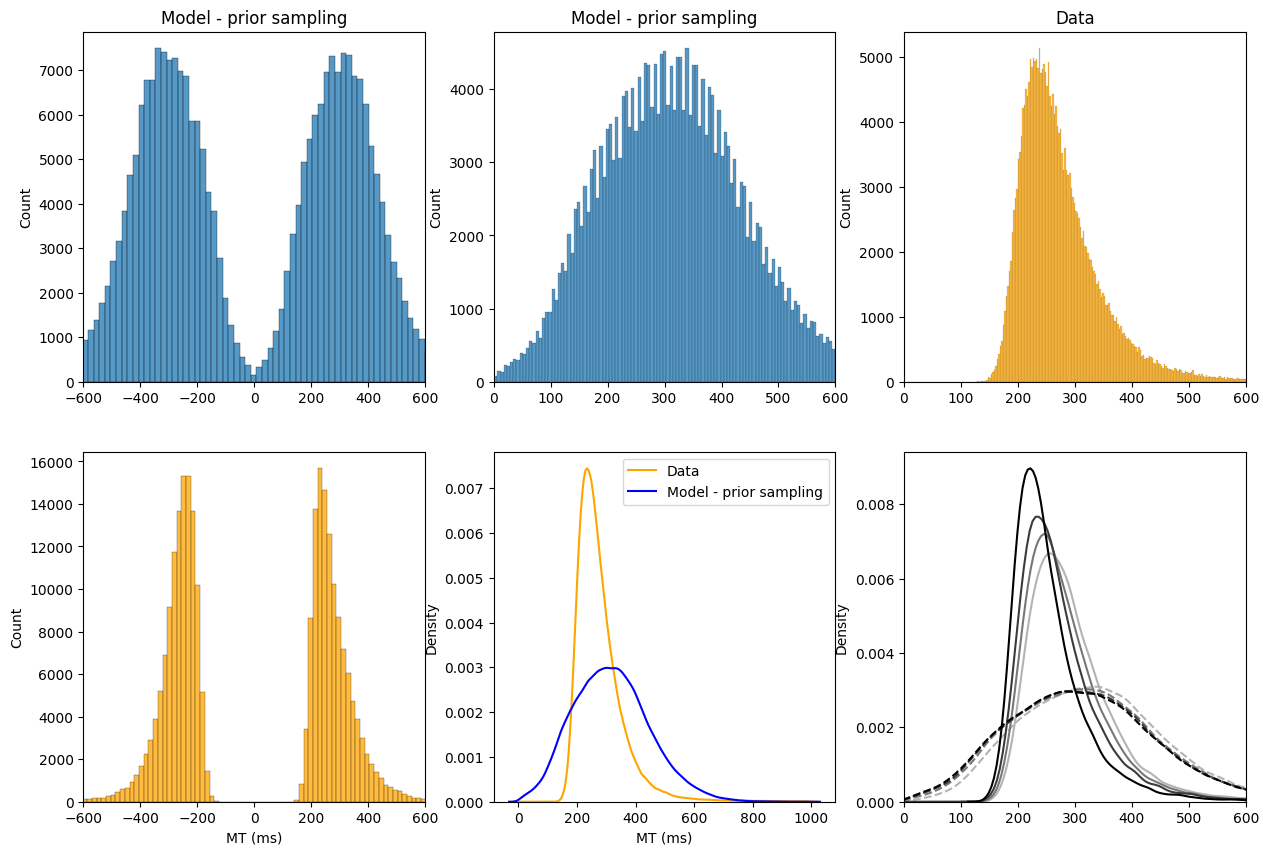

In [11]:
x_syn_1d = x.clone().detach()
x_syn_1d[x_syn_1d[:, 1] < 2, 0] *= -1
mt_sign = np.copy(mt[:num_simulations]*1e3)
mt_sign[choice[:num_simulations] == 0] *= -1
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax = ax.flatten()
sns.histplot(x_syn_1d[:, 0], ax=ax[0])
sns.histplot(x[:,0], ax=ax[1])
sns.histplot(mt*1e3, color='orange', ax=ax[2])
sns.histplot(mt_sign, color='orange', ax=ax[3])
sns.kdeplot(mt*1e3, color='orange', ax=ax[4], label='Data')
sns.kdeplot(x[:,0], color='blue', ax=ax[4], label='Model - prior sampling')
ax[4].legend()
ax[1].set_title('Model - prior sampling')
ax[0].set_title('Model - prior sampling')
ax[2].set_title('Data')
ax[3].set_xlabel('MT (ms)')
ax[4].set_xlabel('MT (ms)')
for i in range(2):
    ax[i+1].set_xlim(0, 600)
ax[3].set_xlim(-600, 600)
ax[0].set_xlim(-600, 600)

colormap = pl.cm.gist_gray_r(np.linspace(0.3, 1, 4))
for iev, ev in enumerate([0, 0.25, 0.5, 1]):
    index = np.abs(coh) == ev
    sns.kdeplot(mt[np.abs(coh) == ev]*1e3, color=colormap[iev], ax=ax[5])
    sns.kdeplot(x[np.abs(coh[:len(x)]) == ev, 0], color=colormap[iev], ax=ax[5], linestyle='--')
ax[5].set_xlim(0, 600)
plt.show()

In [12]:
assert x.shape == x_o.shape

In [ ]:
"""# No-CoM - CoM
x_syn_1d = x.clone().detach()
x_syn_1d[x_syn_1d[:, 1] == 1, 0] *= -1
mt_sign = np.copy(mt[:num_simulations]*1e3)
mt_sign[com[:num_simulations] == 1] *= -1
fig, ax = plt.subplots(ncols=2, figsize=(7, 3))
ax = ax.flatten()
sns.histplot(x_syn_1d[:, 0], ax=ax[0])
sns.histplot(mt_sign, color='orange', ax=ax[1])

ax[1].set_title('Model - prior sampling')
ax[1].set_title('Data')
ax[1].set_xlabel('MT (ms)')
ax[0].set_xlabel('MT (ms)')
ax[1].set_xlim(-600, 600)
ax[0].set_xlim(-600, 600)
plt.show()"""

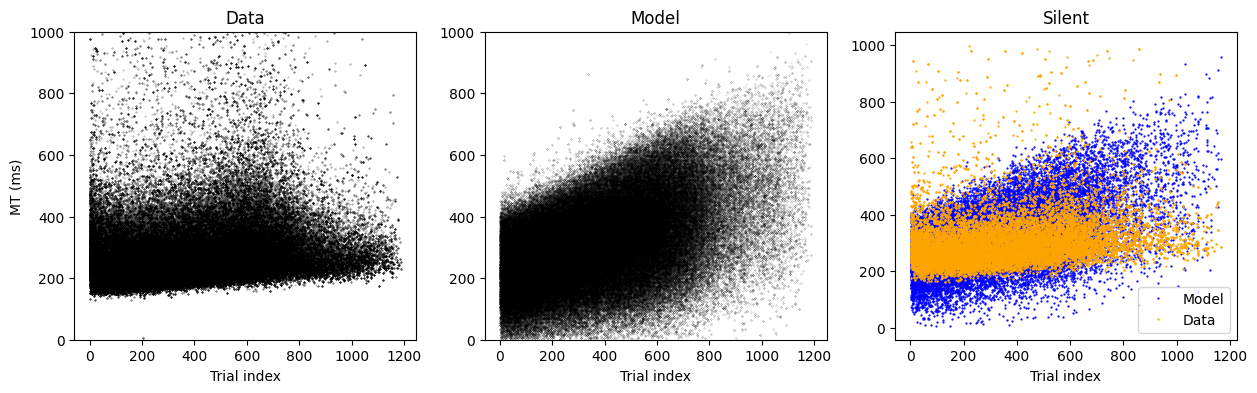

In [13]:
colormap = pl.cm.gist_gray_r(np.linspace(0.3, 1, 4))
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
for iev, ev in enumerate([0, 0.25, 0.5, 1]):
    index = (np.abs(coh) == ev)
    index_mod = index[:len(x)]
    ax[0].plot(trial_index[index][:len(x)], mt[index][:len(x)]*1e3, 'o', markersize=.4, color=colormap[iev])
    ax[1].plot(trial_index[:len(x)][index_mod], x[index_mod, 0], 'o', markersize=.2, color=colormap[iev])
ind_2 = (np.abs(coh) == 0)&(np.resize(df.special_trial.values == 2, num_simulations))
index_mod = ind_2[:len(x)]
ax[2].plot(trial_index[:len(x)][index_mod], x[index_mod, 0], 'o', markersize=.6, color='blue', label='Model')
ax[2].plot(trial_index[ind_2][:len(x)], mt[ind_2][:len(x)]*1e3, 'o', markersize=.6, color='orange', label='Data')

ax[2].set_title('Silent')
ax[2].set_xlabel('Trial index')
ax[2].legend()
ax[0].set_title('Data')
ax[1].set_title('Model')
ax[0].set_xlabel('Trial index')
ax[1].set_xlabel('Trial index')
ax[0].set_ylabel('MT (ms)')
ax[0].set_ylim(0, 1000)
ax[1].set_ylim(0, 1000)
plt.show()

Once we have all the simulated data, we can train the network (filtering nans):

In [14]:
nan_mask = torch.sum(torch.isnan(x), axis=1).to(torch.bool)
trainer = MNLE(prior=prior)
theta_all_inp = theta_all.clone().detach()  # torch.column_stack([theta_all, torch.tensor(coh[:num_simulations]).to(torch.float32)])
theta_all_inp[:, 0] *= torch.tensor(zt[:num_simulations]).to(torch.float32)
theta_all_inp[:, 1] *= torch.tensor(coh[:num_simulations]).to(torch.float32)
theta_all_inp = torch.column_stack((theta_all_inp, torch.tensor(trial_index[:num_simulations].astype(float)).to(torch.float32)))
theta_all_inp = theta_all_inp.to(torch.float32)

In [ ]:
time_start = time.time()
estimator = trainer.append_simulations(theta_all_inp[~nan_mask, :],
                                       x[~nan_mask, :]).train(show_train_summary=True)
print('For a batch of ' + str(num_simulations) + ' simulations, it took ' + str(int(time.time() - time_start)/60) + ' mins')

C:\Users\agarcia\anaconda3\envs\py39\lib\site-packages\sbi\neural_nets\mnle.py:60: UserWarning: The mixed neural likelihood estimator assumes that x contains
        continuous data in the first n-1 columns (e.g., reaction times) and
        categorical data in the last column (e.g., corresponding choices). If
        this is not the case for the passed `x` do not use this function.
  warnings.warn(


 Training neural network. Epochs trained: 50

Now we will use ```PyBADS``` for MLE:

In [ ]:
mt = df.resp_len.values
choice = df.R_response.values
zt = np.nansum(df[["dW_lat", "dW_trans"]].values, axis=1)
stim = np.array([stim for stim in df.res_sound])
coh = np.array(df.coh2)
trial_index = np.array(df.origidx)
gt = np.array(df.rewside) * 2 - 1
global x_o
global trial_index
global coh
global zt
global num_simulations
def fun_theta(theta):
#     x_cond = torch.column_stack([torch.tensor(coh), torch.tensor(zt), torch.tensor(trial_index.astype(float)).to(torch.float32)])
    theta = torch.reshape(torch.tensor(theta), (1, len(theta))).to(torch.float32)
    theta = theta.repeat(num_simulations, 1)
    theta[:, 0] *= torch.tensor(zt[:num_simulations])
    theta[:, 1] *= torch.tensor(coh[:num_simulations])
    t_i = torch.tensor(trial_index[:num_simulations].astype(float)).to(torch.float32)
    theta = torch.column_stack((theta, t_i))
    log_liks = estimator.log_prob(x_o[:num_simulations], context=theta)
    return -torch.nansum(log_liks).detach().numpy()

In [ ]:
x0 = theta_all_inp[torch.argmin(-estimator.log_prob(x_o[:num_simulations], context=theta_all_inp)), :-1]
print('Initial guess is: ' + str(x0))

In [ ]:
tim_st = time.time()
estimator.log_prob(x_o[:num_simulations], context=theta_all_inp)
print(str(round(time.time()-tim_st, 2)) + ' seconds')

In [ ]:
# x0 = prior.sample((1, ))
x0[0] = 0.5
x0[1] = 0.5
lb = np.array([np.float64(prior.dists[i].low/10) for i in range(len(prior.dists))])
ub = np.array([np.float64(prior.dists[i].high*100) for i in range(len(prior.dists))])
pub = np.array([np.float64(prior.dists[i].high) for i in range(len(prior.dists))])
plb = np.array([np.float64(prior.dists[i].low) for i in range(len(prior.dists))])
# x0 = (pub + plb)/2
bads = BADS(fun_theta, x0, lb, ub, plb, pub)

In [ ]:
optimize_result = bads.optimize()

The best parameters for this rat and 120000 simulations (fitted for choice & MT) are:

In [ ]:
optimize_result.x

Now we can build the posterior distributon

In [ ]:
# Markov chain Monte-Carlo (MCMC) to get posterior distros
num_samples = 10000

mcmc_parameters = dict(num_chains=4, thin=10,
                       warmup_steps=num_samples//4,
                       init_strategy="proposal",
                       num_workers=1,)
mnle_posterior = trainer.build_posterior(prior=prior,
                                         mcmc_method="hmc",
                                         mcmc_parameters=mcmc_parameters)


Now we extract samples for the posterior using MCMC, to get a distro of each parameter.

In [ ]:
# at this point, we should re-simulate the model with all trials
# mnle_samples = mnle_posterior.sample((num_samples,), x=x_o,
#                                      show_progress_bars=True)

Or we can use ```arviz```

In [ ]:
# import arviz as az
# # get arviz InferenceData object from posterior
# inference_data = mnle_posterior.get_arviz_inference_data()
# print(inference_data.posterior)
